Mevcut sütunlar: ['Tarih', 'hour', 'total', 'consumption', 'day', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_24_gen', 'lag_168_gen', 'lag_336_gen', 'rolling_mean_24h_gen', 'rolling_mean_168h_gen', 'rolling_std_24h_gen', 'trend_24h_gen', 'trend_168h_gen']
Epoch [1/50], Train Loss: 0.0063, Val Loss: 0.0056
Epoch [2/50], Train Loss: 0.0019, Val Loss: 0.0041
Epoch [3/50], Train Loss: 0.0015, Val Loss: 0.0071
Epoch [4/50], Train Loss: 0.0013, Val Loss: 0.0029
Epoch [5/50], Train Loss: 0.0011, Val Loss: 0.0033
Epoch [6/50], Train Loss: 0.0011, Val Loss: 0.0026
Epoch [7/50], Train Loss: 0.0010, Val Loss: 0.0022
Epoch [8/50], Train Loss: 0.0009, Val Loss: 0.0031
Epoch [9/50], Train Loss: 0.0009, Val Loss: 0.0027
Epoch [10/50], Train Loss: 0.0009, Val Loss: 0.0018
Epoch [11/50], Train Loss: 0.0008, Val Loss: 0.0019
Epoch [12/50], Train Loss: 0.0008, Val Loss: 0.0020
Epoch [13/50], Train Loss: 0.0008, Val Loss: 0.0022
Epoch [14/50], Train Loss: 0

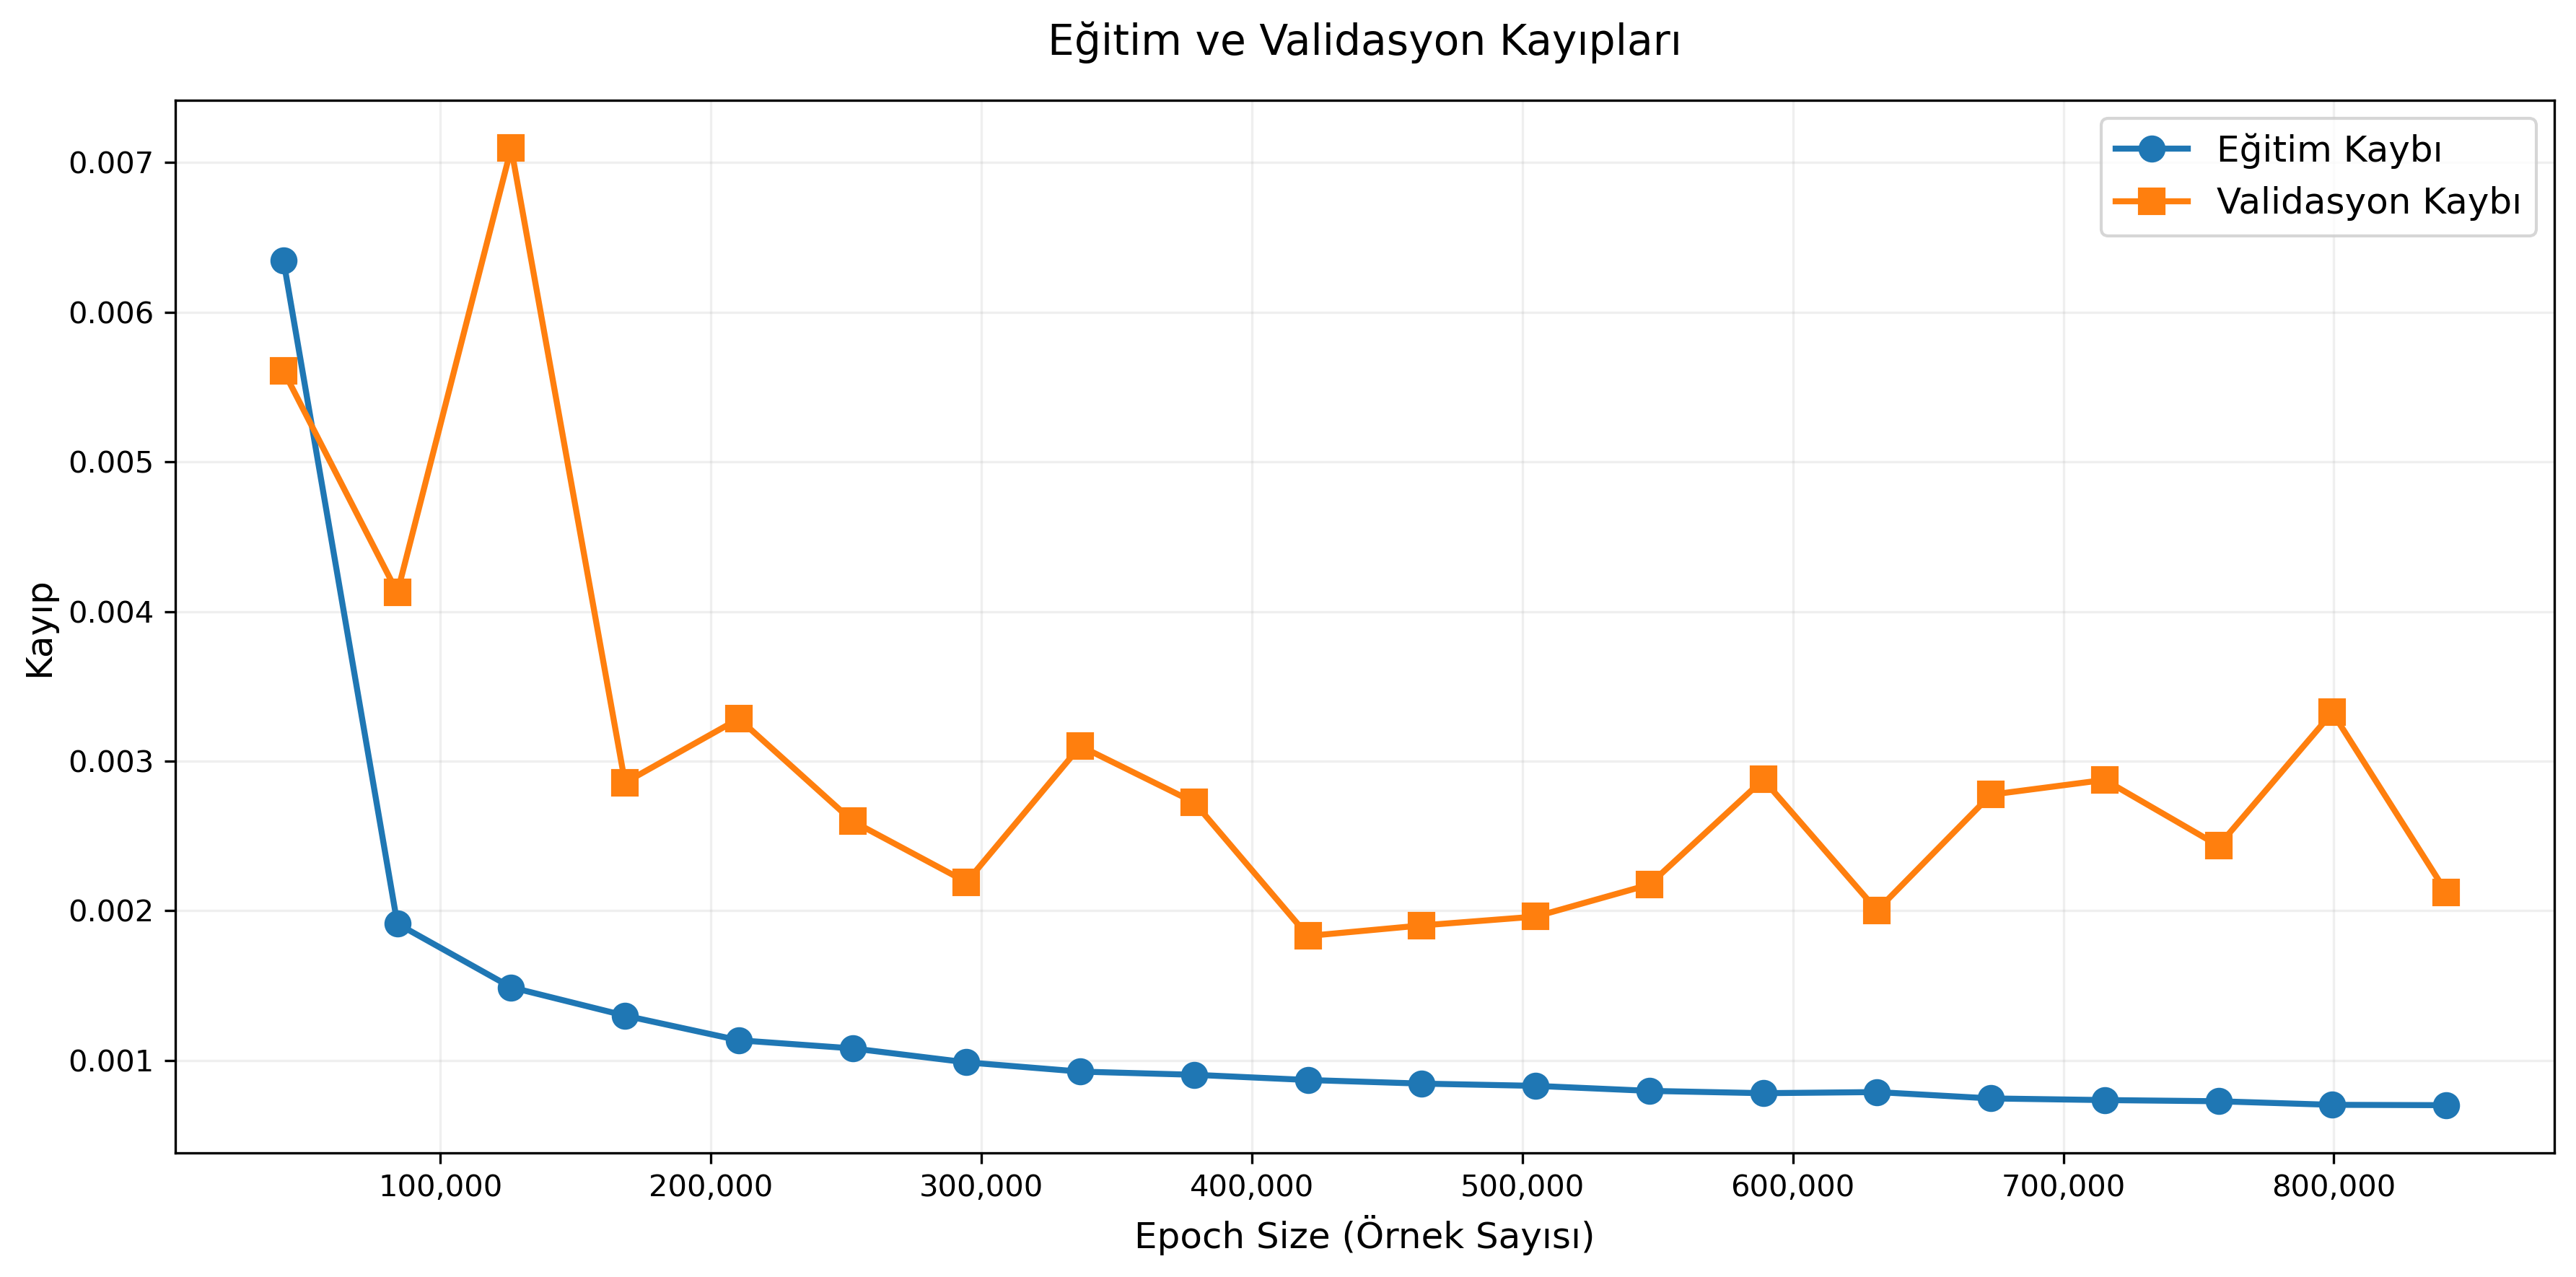


=== Model Performans Metrikleri ===
MSE     : 3300064.75
RMSE    : 1816.61
MAE     : 1329.16
MAPE    : 3.38%
R²      : 0.9178

Model Performans Süreleri:
     Model Training Time (s) Inference Time (s)
Pyraformer            205.04               0.67


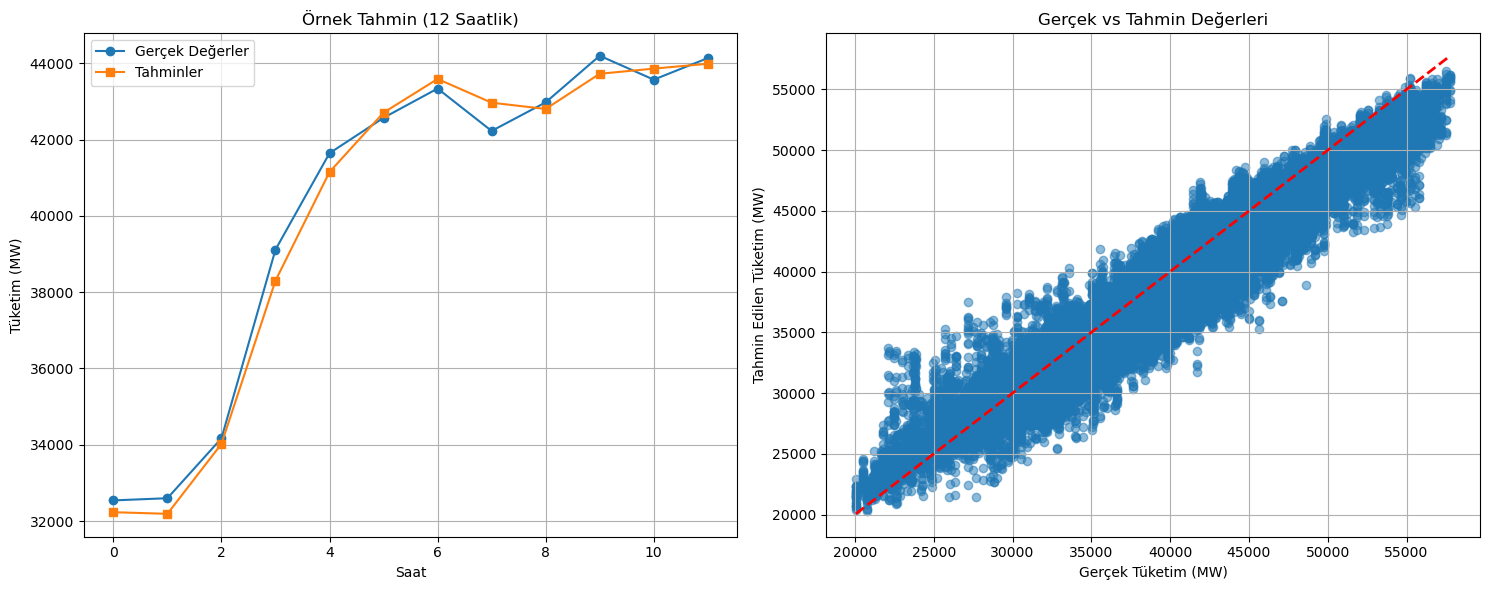

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

def load_data(generation_path: str, consumption_path: str) -> pd.DataFrame:
    df_gen = pd.read_csv(generation_path)
    df_cons = pd.read_csv(consumption_path)
    
    df_gen['Tarih'] = pd.to_datetime(df_gen['Tarih'] + ' ' + df_gen['hour'], format='%d.%m.%Y %H:%M')
    df_cons['Tarih'] = pd.to_datetime(df_cons['Tarih'] + ' ' + df_cons['hour'], format='%d.%m.%Y %H:%M')
    
    df = pd.merge(df_gen, df_cons[['Tarih', 'consumption']], on='Tarih', how='inner')
    return df

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    df['lag_24_gen'] = df['total'].shift(24)   
    df['lag_168_gen'] = df['total'].shift(168)  
    df['lag_336_gen'] = df['total'].shift(336) 
    
    df['rolling_mean_24h_gen'] = df['total'].rolling(window=24).mean()
    df['rolling_mean_168h_gen'] = df['total'].rolling(window=168).mean()
    df['rolling_std_24h_gen'] = df['total'].rolling(window=24).std()
    
    df['trend_24h_gen'] = df['total'].diff(24)
    df['trend_168h_gen'] = df['total'].diff(168)
    
    df = df.bfill()
    df = df.ffill()
    
    return df

def prepare_data_for_pyraformer(df: pd.DataFrame, feature_columns: list, seq_len: int = 24, pred_len: int = 12):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X = df[feature_columns].values
    y = df['consumption'].values.reshape(-1, 1)
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    X_sequences = []
    y_sequences = []
    
    for i in range(len(df) - seq_len - pred_len + 1):
        X_sequences.append(X_scaled[i:(i + seq_len)])
        y_sequences.append(y_scaled[(i + seq_len):(i + seq_len + pred_len)])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    train_size = int(0.8 * len(X_sequences))
    
    X_train = X_sequences[:train_size]
    y_train = y_sequences[:train_size]
    X_test = X_sequences[train_size:]
    y_test = y_sequences[train_size:]
    
    return (X_train, y_train, X_test, y_test), (scaler_X, scaler_y)

def create_model(input_size, pred_len=12):
    class PyraformerBlock(nn.Module):
        def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
            super().__init__()
            d_ff = d_ff or 4 * d_model
            
            self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
            
            self.ff = nn.Sequential(
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model)
            )
            
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
            
            self.dropout = nn.Dropout(dropout)

        def forward(self, x):
            attn_output, _ = self.attention(x, x, x)
            x = x + self.dropout(attn_output)
            x = self.norm1(x)
            
            ff_output = self.ff(x)
            x = x + self.dropout(ff_output)
            x = self.norm2(x)
            
            return x

    class Pyraformer(nn.Module):
        def __init__(self, input_size, d_model=64, n_heads=8, n_layers=3, dropout=0.1, pred_len=12):
            super().__init__()
            
            self.pred_len = pred_len
            
            self.input_projection = nn.Linear(input_size, d_model)
            
            self.layers = nn.ModuleList([
                PyraformerBlock(d_model, n_heads, dropout=dropout)
                for _ in range(n_layers)
            ])
            
            self.output_projection = nn.Linear(d_model, pred_len)
            
        def forward(self, x):
            
            x = self.input_projection(x)
            
            for layer in self.layers:
                x = layer(x)
            
            x = x[:, -1, :]  
            
            x = self.output_projection(x) 
            
            return x.unsqueeze(-1)  

    model = Pyraformer(
        input_size=input_size,
        d_model=128,
        n_heads=8,
        n_layers=3,
        dropout=0.1,
        pred_len=pred_len
    )
    
    return model

def train_model(model, train_loader, test_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    best_model = None
    patience = 10
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    epoch_sizes = []
    
    training_start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(test_loader))
        epoch_sizes.append((epoch + 1) * len(train_loader.dataset))
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')
    
    training_time = time.time() - training_start_time
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(epoch_sizes, train_losses, '-o', color='#1f77b4', label='Eğitim Kaybı', linewidth=2, markersize=8)
    plt.plot(epoch_sizes, val_losses, '-s', color='#ff7f0e', label='Validasyon Kaybı', linewidth=2, markersize=8)
    
    plt.title('Eğitim ve Validasyon Kayıpları', fontsize=14, pad=15)
    plt.xlabel('Epoch Size (Örnek Sayısı)', fontsize=12)
    plt.ylabel('Kayıp', fontsize=12)
    plt.grid(True, linestyle='-', alpha=0.2)
    plt.legend(fontsize=12)
    
    plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.tight_layout()
    
    plt.savefig('epoch_size_vs_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_model, training_time

def calculate_metrics(actuals, predictions):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    r2 = r2_score(actuals, predictions)
    
    print("\n=== Model Performans Metrikleri ===")
    print(f"MSE     : {mse:.2f}")
    print(f"RMSE    : {rmse:.2f}")
    print(f"MAE     : {mae:.2f}")
    print(f"MAPE    : {mape:.2f}%")
    print(f"R²      : {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

def visualize_results(predictions, actuals):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    feature_columns = [
        'total',         
        'hour', 'day_of_week', 'is_weekend',  
        'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
        'lag_24_gen', 'lag_168_gen', 'lag_336_gen', 
        'rolling_mean_24h_gen', 'rolling_mean_168h_gen', 'rolling_std_24h_gen',  
        'trend_24h_gen', 'trend_168h_gen'  
    ]
    
    df = load_data('csv_files/realtime_generation_data.csv', 
                   'csv_files/realtime_consumption_data.csv')
    
    df = create_features(df)
    
    print("Mevcut sütunlar:", df.columns.tolist())
    missing_features = [col for col in feature_columns if col not in df.columns]
    if missing_features:
        print("Eksik sütunlar:", missing_features)
        raise ValueError(f"Bu sütunlar eksik: {missing_features}")
    
    (X_train, y_train, X_test, y_test), (scaler_X, scaler_y) = prepare_data_for_pyraformer(df, feature_columns)
    
    model = create_model(input_size=len(feature_columns))
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
    
    best_model, training_time = train_model(model, train_loader, test_loader)
    
    inference_start_time = time.time()
    best_model.eval()
    predictions_list = []
    with torch.no_grad():
        for i in range(0, len(X_test), 32):
            batch_x = X_test[i:i+32]
            batch_pred = best_model(batch_x)
            predictions_list.append(batch_pred.cpu())
    inference_time = time.time() - inference_start_time
    
    predictions = torch.cat(predictions_list, dim=0)
    predictions = predictions.squeeze(-1).numpy()
    actuals = y_test.cpu().squeeze(-1).numpy()
    
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    metrics = calculate_metrics(actuals.reshape(-1), predictions.reshape(-1))
    
    performance_metrics = {
        'Model': ['Pyraformer'],
        'Training Time (s)': [f"{training_time:.2f}"],
        'Inference Time (s)': [f"{inference_time:.2f}"]
    }
    
    metrics_df = pd.DataFrame(performance_metrics)
    print("\nModel Performans Süreleri:")
    print(metrics_df.to_string(index=False))
    
    metrics_df.to_csv('model_performance_metrics.csv', index=False)
    
    visualize_results(predictions, actuals)

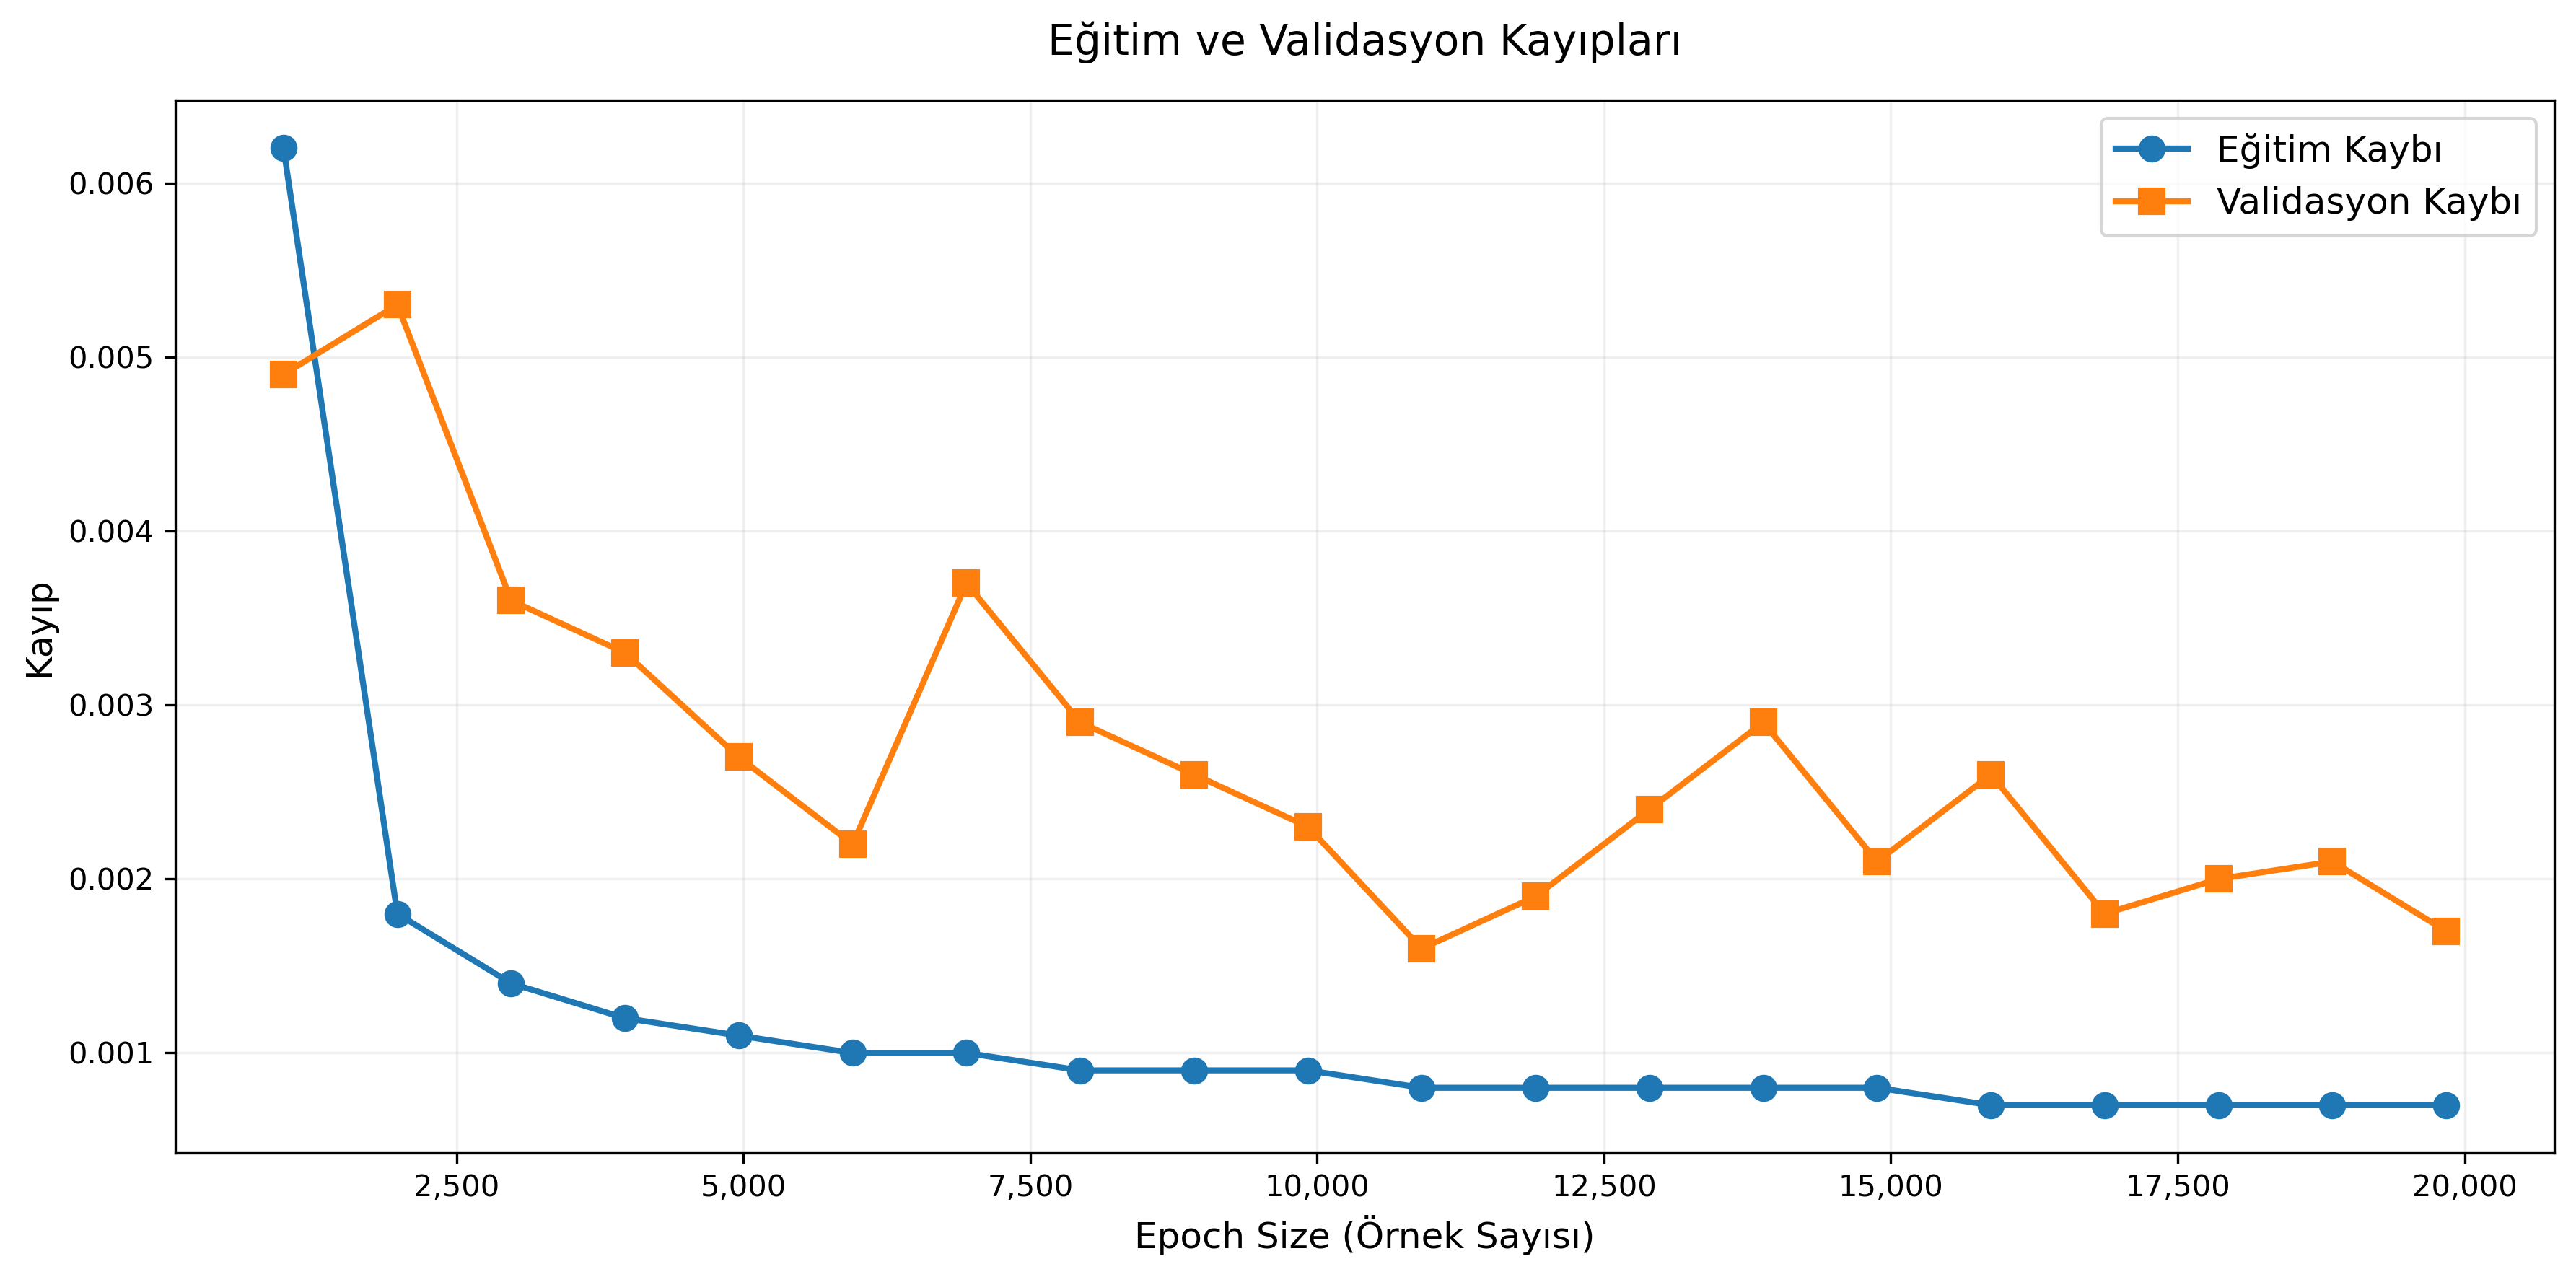


Eğitim İstatistikleri:
Minimum Eğitim Kaybı: 0.000700
Minimum Validasyon Kaybı: 0.001600
Son Eğitim Kaybı: 0.000700
Son Validasyon Kaybı: 0.001700


In [2]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [0.0062, 0.0018, 0.0014, 0.0012, 0.0011, 0.0010, 0.0010, 0.0009, 0.0009, 0.0009, 
                0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007]
val_losses = [0.0049, 0.0053, 0.0036, 0.0033, 0.0027, 0.0022, 0.0037, 0.0029, 0.0026, 0.0023, 
              0.0016, 0.0019, 0.0024, 0.0029, 0.0021, 0.0026, 0.0018, 0.0020, 0.0021, 0.0017]

batch_size = 32
num_samples = 1000 
iterations_per_epoch = num_samples // batch_size
epoch_sizes = [i * iterations_per_epoch * batch_size for i in range(1, len(train_losses) + 1)]

plt.figure(figsize=(12, 6), dpi=300)

plt.plot(epoch_sizes, train_losses, '-o', color='#1f77b4', label='Eğitim Kaybı', 
         linewidth=2, markersize=8)  
plt.plot(epoch_sizes, val_losses, '-s', color='#ff7f0e', label='Validasyon Kaybı', 
         linewidth=2, markersize=8)  

plt.title('Eğitim ve Validasyon Kayıpları', fontsize=14, pad=15)
plt.xlabel('Epoch Size (Örnek Sayısı)', fontsize=12)
plt.ylabel('Kayıp', fontsize=12)
plt.grid(True, linestyle='-', alpha=0.2) 
plt.legend(fontsize=12)

plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()

plt.savefig('epoch_size_vs_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEğitim İstatistikleri:")
print(f"Minimum Eğitim Kaybı: {min(train_losses):.6f}")
print(f"Minimum Validasyon Kaybı: {min(val_losses):.6f}")
print(f"Son Eğitim Kaybı: {train_losses[-1]:.6f}")
print(f"Son Validasyon Kaybı: {val_losses[-1]:.6f}")